Classification of domestic and wild cats using transfer learning

First built feed forward fully connected CNN and after that transfer learning model using VGG16

In [ ]:
!unzip animals_dataset.zip

Archive:  animals_dataset.zip
   creating: animals_dataset/
   creating: animals_dataset/cats/
  inflating: animals_dataset/.DS_Store  
  inflating: __MACOSX/animals_dataset/._.DS_Store  
   creating: animals_dataset/big_cats/
  inflating: animals_dataset/cats/flickr_cat_000619.jpg  
  inflating: __MACOSX/animals_dataset/cats/._flickr_cat_000619.jpg  
  inflating: animals_dataset/cats/flickr_cat_000143.jpg  
  inflating: __MACOSX/animals_dataset/cats/._flickr_cat_000143.jpg  
  inflating: animals_dataset/cats/flickr_cat_000625.jpg  
  inflating: __MACOSX/animals_dataset/cats/._flickr_cat_000625.jpg  
  inflating: animals_dataset/cats/flickr_cat_000631.jpg  
  inflating: __MACOSX/animals_dataset/cats/._flickr_cat_000631.jpg  
  inflating: animals_dataset/cats/flickr_cat_000157.jpg  
  inflating: __MACOSX/animals_dataset/cats/._flickr_cat_000157.jpg  
  inflating: animals_dataset/cats/flickr_cat_000802.jpg  
  inflating: __MACOSX/animals_dataset/cats/._flickr_cat_000802.jpg  
  inflating

Splitting the dataset, creating train and test folders

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/animals_dataset' #path of the original folder

classes = ['cats', 'big_cats']

for i in classes:
  os.makedirs(rootdir +'/train/' + i)
  os.makedirs(rootdir +'/test/' + i)
  source = rootdir + '/' + i
  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  test_ratio = 0.2
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])
  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
  
  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + i)
  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + i)

In [ ]:
# define and move to dataset directory
datasetdir = '/content/animals_dataset/train'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
# shortcut to the ImageDataGenerator class
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

Investigating dataset

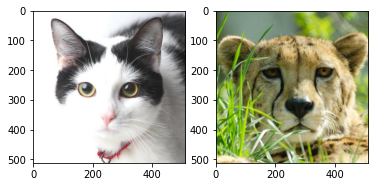

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img.imread('cats/flickr_cat_000113.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('big_cats/flickr_wild_000711.jpg'))

Loading the datset with keras

In [ ]:
gen = ImageDataGenerator()

Data Preprocessing, here downsampling the images with the help of target_image

In [ ]:
iterator = gen.flow_from_directory(
    os.getcwd(), 
    target_size=(256,256), 
    classes=('cats','big_cats')
)
print(os.getcwd())

Found 1280 images belonging to 2 classes.
/content/animals_dataset/train


In [ ]:
# we can guess that the iterator has a next function, 
# because all python iterators have one. 
batch = iterator.next()
len(batch)

2

In [ ]:
print(type(batch[0]))
print(type(batch[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Info about dimensions, colour of dataset images

In [ ]:
print(batch[0].shape)
print(batch[0].dtype)
print(batch[0].max())
print(batch[1].shape)
print(batch[1].dtype)

(32, 256, 256, 3)
float32
255.0
(32, 2)
float32


Using label info to print image

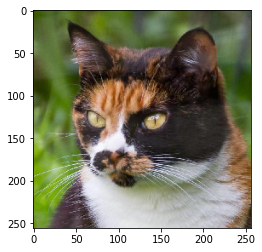

In [ ]:
import numpy as np
# we need to cast the image array to integers 
# before plotting as imshow either takes arrays of integers, 
# or arrays of floats normalized to 1. 
plt.imshow(batch[0][0].astype(np.int))

corresponding label

In [ ]:
batch[1][0]

array([1., 0.], dtype=float32)

label validation

In [ ]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img.astype(np.int))
      assert(label[0]+label[1]==1.)
      categ = 'cat' if label[0]>0.5 else 'big_cat'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')

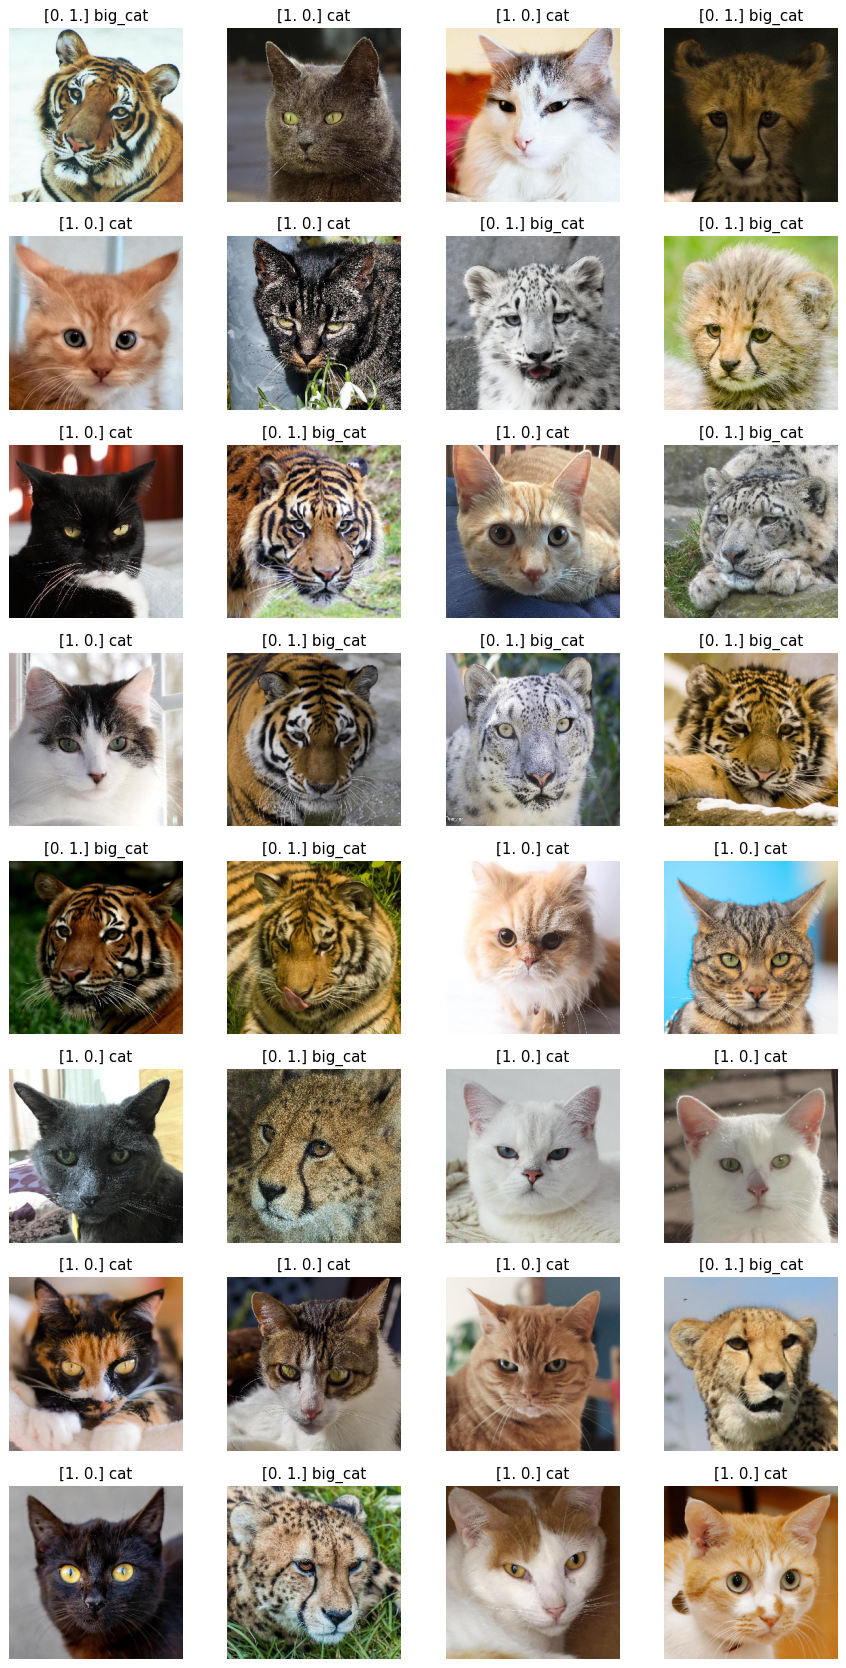

In [ ]:
plot_images(iterator.next())

Split the training and validation dataset with ImageDataGenerator

In [ ]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    validation_split = 0.2,
)

In [ ]:
batch_size = 32
height, width = (256,256)

train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('cats','big_cats'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('cats','big_cats'),
    batch_size = batch_size,
    subset = 'validation'
)

Found 1024 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Fully connected feed forward Neural Network

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256, 256, 50)      200       
_________________________________________________________________
dense_1 (Dense)              (None, 256, 256, 50)      2550      
_________________________________________________________________
dense_2 (Dense)              (None, 256, 256, 24)      1224      
_________________________________________________________________
flatten (Flatten)            (None, 1572864)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1572864)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3145730   
Total params: 3,149,704
Trainable params: 3,149,704
Non-trainable params: 0
______________________________________________

Optimizer

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])

Model Training

In [ ]:
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/animals_dataset/img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

In [ ]:
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
32/32 [==============================] - 17s 452ms/step - loss: 3.4787 - acc: 0.5295 - val_loss: 0.6305 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.63052, saving model to /content/animals_dataset/img_model.weights.best.hdf5
Epoch 2/20
32/32 [==============================] - 15s 423ms/step - loss: 0.5479 - acc: 0.7570 - val_loss: 0.4722 - val_acc: 0.8008

Epoch 00002: val_loss improved from 0.63052 to 0.47221, saving model to /content/animals_dataset/img_model.weights.best.hdf5
Epoch 3/20
32/32 [==============================] - 15s 422ms/step - loss: 0.2961 - acc: 0.9048 - val_loss: 0.6222 - val_acc: 0.6680

Epoch 00003: val_loss did not improve from 0.47221
Epoch 4/20
32/32 [==============================] - 16s 422ms/step - loss: 0.2306 - acc: 0.9114 - val_loss: 0.5503 - val_acc: 0.7422

Epoch 00004: val_loss did not improve from 0.47221
Epoch 5/20
32/32 [==============================] - 15s 422ms/step - loss: 0.2091 - acc: 0.9187 - val_loss: 0.6246 -

Function to plot the loss and accuracy for both the training and validation datasets

In [ ]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='training')
    plt.plot(epochs, val_acc,label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    plt.legend()
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss, label='training')
    plt.plot(epochs, val_loss, label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

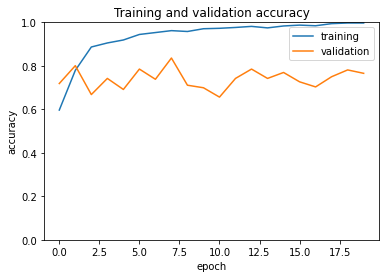

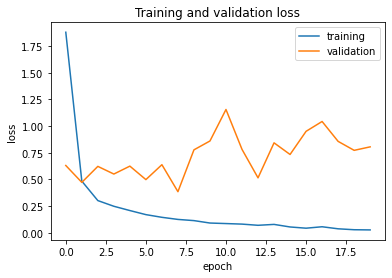

In [ ]:
plot_history(history, (0, 1.))

Testing our model

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/animals_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)


Found 320 images belonging to 2 classes.


In [ ]:
model.load_weights('/content/animals_dataset/img_model.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'cats': 0, 'big_cats': 1}


display_results() will compare the images' true labels with the predicted labels.

plot_predictions() will allow us to visualize a sample of the test images, and the labels that the model generates.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

def display_results(y_true, y_preds, class_labels):
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spf1 = tp / (tp + fp)
    spf2 = tn / (tn+fp)
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
                          
    results.insert(4,'Specificity', [spf1, spf2],True)
    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support', 4: 'Specificity'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("\u001b[1mOverall Categorical Accuracy: {:.2f}%".format(global_acc*100))

    print('\u001b[1mConfusion Matrix')
    print(confusion_matrix(y_true, y_preds))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

Plot to visualize a sample of test dataset images

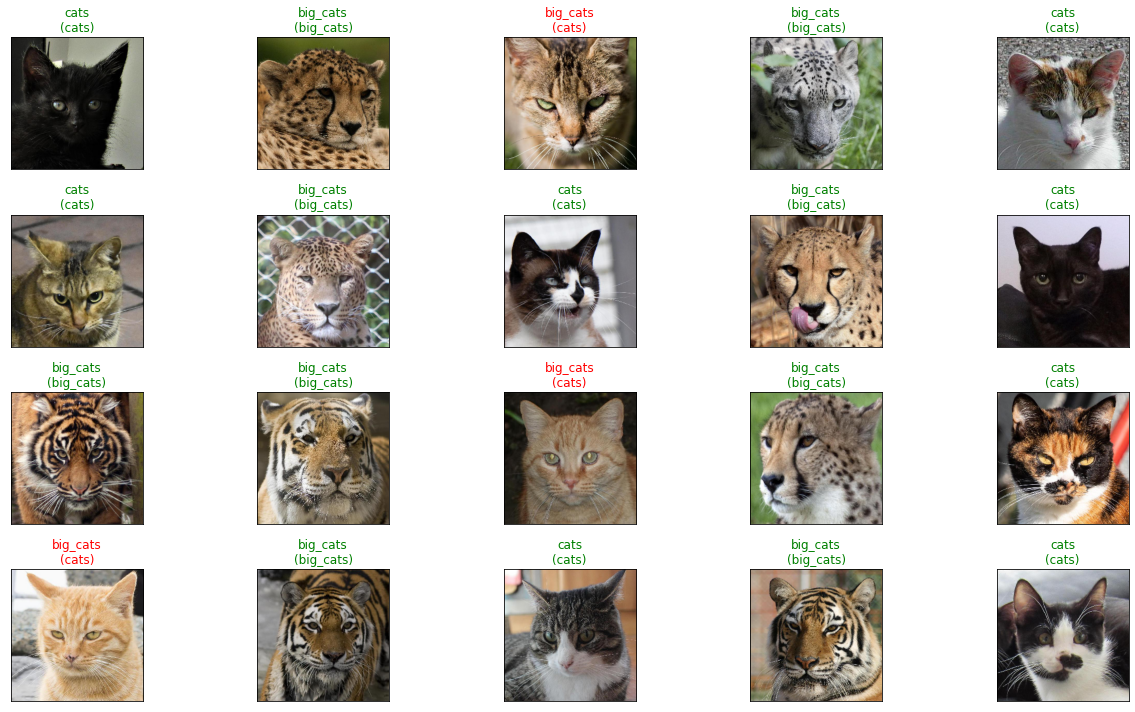

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix


In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 87.50%
Confusion Matrix
[[134  26]
 [ 14 146]]


Precision  Recall   F-Score  Support  Specificity
big_cats   0.848837  0.9125  0.879518    160.0     0.837500
cats       0.905405  0.8375  0.870130    160.0     0.848837

Probability of test dataset belonging to {domestic , wild}

wild is labeled as 1

{'cats': 0, 'big_cats': 1}

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
prob_domestic_wild = model.predict_proba(testgen, batch_size= batch_size, verbose=1)
print(prob_domestic_wild)

  9/320 [..............................] - ETA: 4s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


320/320 [==============================] - 3s 11ms/step
[[0.99964225 0.00035776]
 [0.97156715 0.02843283]
 [0.9999926  0.00000741]
 [0.9998424  0.00015758]
 [0.99977726 0.0002228 ]
 [0.21143974 0.7885603 ]
 [0.11093891 0.8890611 ]
 [0.77968377 0.22031629]
 [0.99907255 0.00092742]
 [0.05830635 0.94169366]
 [0.99600947 0.00399054]
 [0.99986994 0.00013004]
 [0.9999769  0.00002314]
 [0.6285362  0.3714638 ]
 [0.99991727 0.00008273]
 [0.9999943  0.00000568]
 [0.9970264  0.00297358]
 [1.         0.        ]
 [0.9898039  0.01019605]
 [0.75797206 0.24202794]
 [0.9999975  0.00000256]
 [0.9987691  0.00123092]
 [0.00040377 0.9995963 ]
 [0.9999939  0.00000602]
 [0.9769398  0.02306014]
 [0.10756136 0.8924386 ]
 [0.99800736 0.00199265]
 [0.9999974  0.00000261]
 [0.99176764 0.00823227]
 [0.9959728  0.0040272 ]
 [0.99900395 0.00099603]
 [0.9994103  0.0005897 ]
 [0.9401942  0.0598058 ]
 [0.9997739  0.00022612]
 [1.         0.        ]
 [0.99898165 0.00101826]
 [0.9999844  0.00001567]
 [0.16020067 0.8397

Probability of each test dataset image falling into positive class

wild is labeled as 1

{'cats': 0, 'big_cats': 1}

image path---------> prob(image belongs to wild dataset)

In [ ]:
print("%-70s %-10s" % ("Image_Path", "Probability( Wild)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_domestic_wild[i][1]))

Image_Path                                                             Probability( Wild)
/content/animals_dataset/test/cats/flickr_cat_000027.jpg               0.0004    
/content/animals_dataset/test/cats/flickr_cat_000029.jpg               0.0284    
/content/animals_dataset/test/cats/flickr_cat_000030.jpg               0.0000    
/content/animals_dataset/test/cats/flickr_cat_000035.jpg               0.0002    
/content/animals_dataset/test/cats/flickr_cat_000037.jpg               0.0002    
/content/animals_dataset/test/cats/flickr_cat_000043.jpg               0.7886    
/content/animals_dataset/test/cats/flickr_cat_000049.jpg               0.8891    
/content/animals_dataset/test/cats/flickr_cat_000052.jpg               0.2203    
/content/animals_dataset/test/cats/flickr_cat_000053.jpg               0.0009    
/content/animals_dataset/test/cats/flickr_cat_000058.jpg               0.9417    
/content/animals_dataset/test/cats/flickr_cat_000062.jpg               0.0040    
/content

Transfer Learning using VGG16 pretrained on ImageNet(Weights='imagenet')

In [ ]:
def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.2,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('cats','big_cats'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('cats','big_cats'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset
    

Feature extraction with VGG16

VGG16 pretrained on ImageNet(Weights='imagenet')

In [ ]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights='imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Custom Classification with VGG16, the input of VGG16 should be images with 224x224 pixels.

In [ ]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 1024 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

plug the output of the convolutional part into a classifier

In [ ]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories ( cats and big_cats)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in conv_model.layers:
    layer.trainable = False

only layers that will be trained are the ones of the dense classifier

In [ ]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

compile and train the model:

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/animals_dataset/full_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=False)

history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
    callbacks= checkpointer,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
32/32 [==============================] - 15s 402ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 3.4499e-07 - val_acc: 1.0000

Epoch 00001: saving model to /content/animals_dataset/full_model.weights.best.hdf5
Epoch 2/5
32/32 [==============================] - 14s 382ms/step - loss: 1.7091e-12 - acc: 1.0000 - val_loss: 1.4095e-06 - val_acc: 1.0000

Epoch 00002: saving model to /content/animals_dataset/full_model.weights.best.hdf5
Epoch 3/5
32/32 [==============================] - 14s 383ms/step - loss: 7.0559e-11 - acc: 1.0000 - val_loss: 8.0460e-19 - val_acc: 1.0000

Epoch 00003: saving model to /content/animals_dataset/full_model.weights.best.hdf5
Epoch 4/5
32/32 [==============================] - 13s 381ms/step - loss: 1.6191e-12 - acc: 1.0000 - val_loss: 7.1020e-07 - val_acc: 1.0000

Epoch 00004: saving model to /content/animals_dataset/full_model.weights.best.hdf5
Epoch 5/5
32/32 [==============================] - 14s 386ms/step - loss: 1.5890e-11 - acc: 1.0000 - val_los

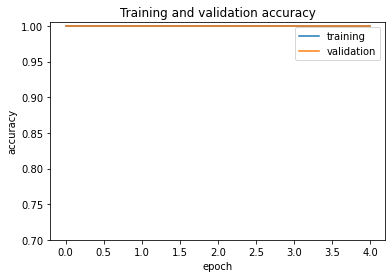

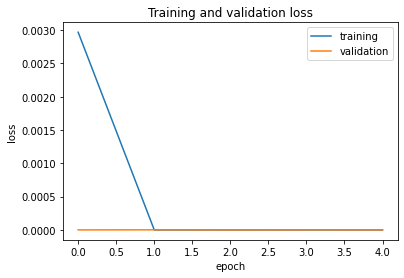

In [ ]:
plot_history(history, yrange=(0.7,1.005))

Testing our transfer trained model on test dataset

In [ ]:
height, width = (224,224)
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/animals_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)


Found 320 images belonging to 2 classes.


In [ ]:
full_model.load_weights('/content/animals_dataset/full_model.weights.best.hdf5')

predicted = full_model.predict(testgen)
predicted_classes = np.argmax(predicted, axis = 1)
class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

{'cats': 0, 'big_cats': 1}


Plot to visualize a sample of test dataset images for the transfer trained model using VGG16

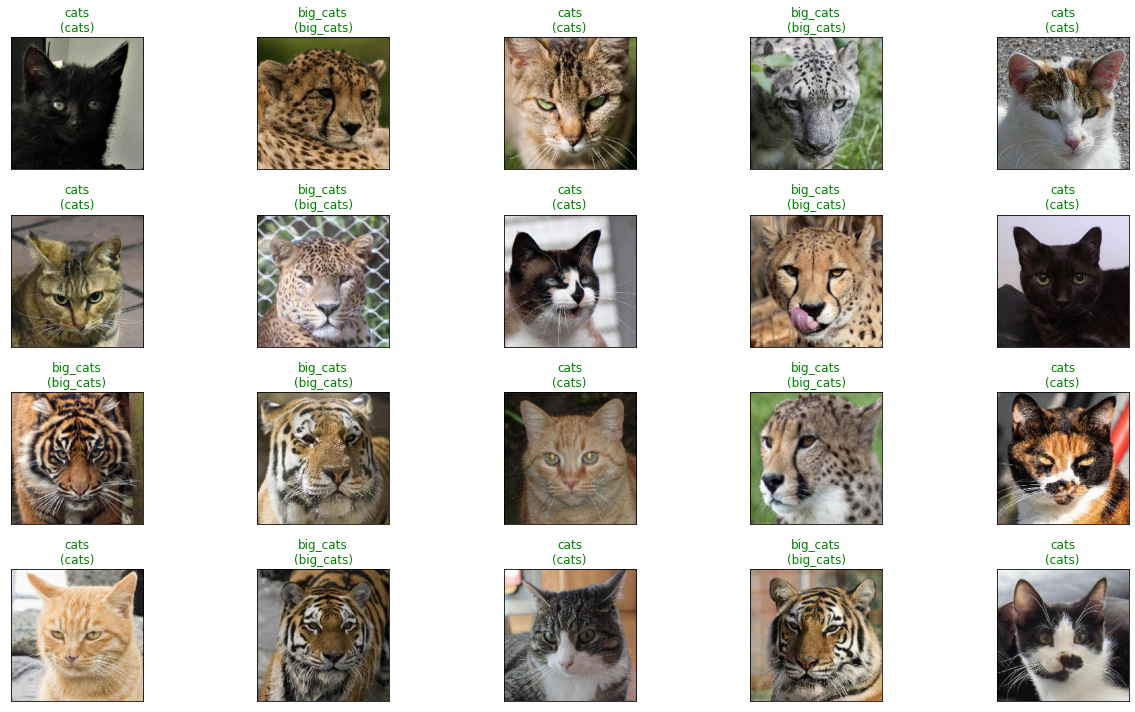

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

VGG16 Transfer trained model(weights='imagenet'):- Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 95.31%
Confusion Matrix
[[160   0]
 [ 15 145]]


Precision   Recall   F-Score  Support  Specificity
cats       0.914286  1.00000  0.955224    160.0          1.0
big_cats   1.000000  0.90625  0.950820    160.0          1.0

Probability of test dataset belonging to {domestic , wild} using vgg16(weights='imagenet') transfer trained model

wild is labeled as 1

{'cats': 0, 'big_cats': 1}

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
prob_domestic_wild = full_model.predict(testgen, batch_size= batch_size, verbose=1)
print(prob_domestic_wild)

320/320 [==============================] - 11s 35ms/step
[[0.99657464 0.00342538]
 [0.9845479  0.01545215]
 [0.99903286 0.00096714]
 [0.9981053  0.00189467]
 [0.9855547  0.01444527]
 [0.99084705 0.00915297]
 [0.9885535  0.01144649]
 [0.9880889  0.0119111 ]
 [0.995802   0.00419805]
 [0.9971949  0.00280511]
 [0.99777526 0.00222478]
 [0.99604464 0.00395542]
 [0.99759716 0.00240281]
 [0.9984322  0.00156782]
 [0.9996082  0.00039185]
 [0.983922   0.01607799]
 [0.9954145  0.00458548]
 [0.9766356  0.02336441]
 [0.999278   0.00072204]
 [0.9985827  0.00141733]
 [0.9931126  0.0068874 ]
 [0.9996444  0.00035559]
 [0.94200116 0.05799885]
 [0.9990638  0.00093628]
 [0.9974739  0.00252605]
 [0.98504317 0.01495687]
 [0.99854857 0.00145145]
 [0.9822603  0.01773972]
 [0.9961947  0.00380533]
 [0.9963972  0.00360279]
 [0.99919647 0.00080358]
 [0.998331   0.001669  ]
 [0.9993462  0.00065381]
 [0.99901986 0.00098016]
 [0.9995857  0.00041436]
 [0.99586487 0.00413518]
 [0.999635   0.00036505]
 [0.99216825 0.007

Probability of each test dataset image falling into positive class using VGG16(weights='imagenet') transfer trained model

wild is labeled as 1

{'cats': 0, 'big_cats': 1}

image path---------> prob(image belongs to wild dataset)

In [ ]:
print("%-70s %-10s" % ("Image_Path", "Probability( Wild)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_domestic_wild[i][1]))

Image_Path                                                             Probability( Wild)
/content/animals_dataset/test/cats/flickr_cat_000027.jpg               0.0034    
/content/animals_dataset/test/cats/flickr_cat_000029.jpg               0.0155    
/content/animals_dataset/test/cats/flickr_cat_000030.jpg               0.0010    
/content/animals_dataset/test/cats/flickr_cat_000035.jpg               0.0019    
/content/animals_dataset/test/cats/flickr_cat_000037.jpg               0.0144    
/content/animals_dataset/test/cats/flickr_cat_000043.jpg               0.0092    
/content/animals_dataset/test/cats/flickr_cat_000049.jpg               0.0114    
/content/animals_dataset/test/cats/flickr_cat_000052.jpg               0.0119    
/content/animals_dataset/test/cats/flickr_cat_000053.jpg               0.0042    
/content/animals_dataset/test/cats/flickr_cat_000058.jpg               0.0028    
/content/animals_dataset/test/cats/flickr_cat_000062.jpg               0.0022    
/content